### 0. (Optional) Extract video file

In [1]:
import cv2
import os

capture = cv2.VideoCapture("test_video.avi")
assert capture.isOpened(), "Cannot open the video file."

num_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

# Prepare folders
img_filename_fmt = 'dataset/images/frame_{:09d}.jpg'
dirname = os.path.dirname(img_filename_fmt)
os.makedirs(dirname, exist_ok=True)

for ii in range(num_frames):
    _, frame = capture.read()
    cv2.imwrite(img_filename_fmt.format(ii), frame)

capture.release()

### 1. Resizing images

Resizing pixel of images & Arraying names 

In [ ]:
import cv2
import os
import glob
import natsort
from natsort import natsorted

# The path of the folder containing the images is specified.
folder_path = 'record/20240517_104'
# All jpg files in the folder are targeted. The extension can be changed as needed.
images_path = glob.glob(os.path.join(folder_path, "*.jpg"))
# Use natsort to sort the images in natural order
images_path = natsorted(images_path)

# The name entered directly is used.
input_name = '20240517_104'

for index, img_path in enumerate(images_path):
    # The image is read.
    img = cv2.imread(img_path)
    # # The image is adjusted to 960x540.
    resized_img = cv2.resize(img, (960, 540), interpolation=cv2.INTER_AREA)
    
    # The image is adjusted to 640x640.
    # resized_img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_AREA)
    
    # The adjusted image is overwritten on the original file.
    cv2.imwrite(img_path, resized_img)
    print(f"Overwriting completed on {img_path}.")
    
    # The new name of the image file is set.
    new_img_name = f"{folder_path}/{input_name}_{index}.jpg"
    # The name of the image file is changed.
    os.rename(img_path, new_img_name)
    print(f"{img_path} -> {new_img_name} name change completed.")

### 2. Label images by pointing

In [20]:
import cv2
import os

from collections import defaultdict
from ipywidgets import IntSlider, Label, Button, HBox
from ipycanvas import MultiCanvas, hold_canvas

thickness = 3
y_ratio = 0.5     # percentile of y-position from the top

# Input images
filename = input("데이터셋으로 사용할 파일명 입력:")
img_filename_fmt = 'record/{}/{}_{{}}.jpg'.format(filename, filename)
ann_filename = 'dataset/annotation_straight_370_v4.txt'.format(filename)
ann_dict = defaultdict(list)

num_frames = len(os.listdir(os.path.dirname(img_filename_fmt)))

cur_index = 0
height, width = cv2.imread(img_filename_fmt.format(cur_index)).shape[:2]
    
y_value = int(height * y_ratio)

# 추가된 변수: 선 종류를 저장할 변수
line_type = None

def set_image():        
    image = cv2.imread(img_filename_fmt.format(cur_index))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    image[y_value-thickness//2:y_value+thickness//2] = (255, 0, 0)

    canvas[0].clear()
    canvas[0].put_image_data(image, 0, 0)
    canvas[0].flush()

    pos = ann_dict.get(img_filename_fmt.format(cur_index))
    if pos is not None:
        handle_mouse_down(pos[0], pos[1])    

    cur_fname.value = 'Current image: {:s} | '.format(img_filename_fmt.format(cur_index))

def handle_mouse_move(xpos, ypos):
    with hold_canvas():
        canvas[1].clear()  # Clear the old animation step
        canvas[1].fill_style = "yellow"
        canvas[1].fill_circle(xpos, y_value, 5)  # Draw the new frame    

def handle_mouse_down(xpos, ypos):    
    with hold_canvas():
        canvas[2].clear()
        canvas[2].fill_style = "green"
        canvas[2].fill_circle(xpos, y_value, 5)  # Draw the new frame    

    cur_pos.value = "({:d}, {:d}) ".format(int(xpos), int(y_value))    
    ann_dict[img_filename_fmt.format(cur_index)] = (int(xpos), int(y_value))
    
def handle_slider_change(change):
    global y_value
    y_value = change.new
    set_image()
    canvas[1].clear()
    canvas[2].clear()

def handle_save_button(b):
    with open(ann_filename, 'w') as f:
        for k, v in ann_dict.items():            
            f.write("{:s}\t{:d}\t{:d}\n".format(k, v[0], v[1]))    

def handle_prev_button(b):
    global cur_index
    cur_index = max(0, cur_index - 1)
    canvas.clear()
    set_image()

def handle_next_button(b):
    global cur_index
    cur_index = min(num_frames - 1, cur_index + 1)
    canvas.clear()
    set_image()

canvas = MultiCanvas(3, width=width, height=height)
cur_fname = Label(value='', disabled=False)
cur_pos = Label(value='', disabled=True)
yslider = IntSlider(description="Y-bar: ", stype={'description_width': 'initial'}, value=y_value, min=1, max=height-2, step=1)
prev_btn = Button(description='Prev', icon='arrow-left')
next_btn = Button(description='Next', icon='arrow-right')
save_btn = Button(description='Save labels', icon='check')

set_image()
canvas.on_mouse_move(handle_mouse_move)
canvas.on_mouse_down(handle_mouse_down)
yslider.observe(handle_slider_change, names='value')

prev_btn.on_click(handle_prev_button)
next_btn.on_click(handle_next_button)
save_btn.on_click(handle_save_button)

display(canvas, HBox([cur_fname, cur_pos, yslider]), HBox([prev_btn, next_btn, save_btn]))

MultiCanvas(height=540, width=960)

### 3. Train a model

In [2]:
import torch
print(torch. __version__)
print(torch.cuda.is_available())

2.3.0
True


In [3]:
import tensorrt
print(tensorrt.__version__)
# assert tensorrt.Builder(tensorrt.Logger())

8.5.2.2


YOLO to Tensor RT

In [3]:
import tensorrt as trt

from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('240515_002.pt')

# Export the model to TensorRT format
model.export(format='engine',device = 0, half = True)  # creates 'yolov8n.engine'

# # Load the exported TensorRT model
# tensorrt_model = YOLO('240515_002.engine', task='detect')

# # Run inference
# results = tensorrt_model('20240513_008/20240513_008_13.jpg')



Ultralytics YOLOv8.2.8  Python-3.8.10 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 3006623 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '240515_002.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 9, 3549) (5.9 MB)
requirements: Ultralytics requirements ['onnxsim>=0.4.33', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
requirements:  AutoUpdate skipped (offline)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: simplifier failure: No module named 'onnxsim'
ONNX: export success  0.7s, saved as '240515_002.onnx' (11.6 MB)

TensorRT: starting export with TensorRT 8.5.2.2...
TensorRT: input "images" with shape(1, 3, 416, 416) DataType.FLOAT
TensorRT: output "output0" with shape(1, 9, 3549) DataType.FLOAT
TensorRT: building FP16 engine as 240515_002.engine
TensorRT: export success  310.7s, saved as '240515_002.engine' (8.3 MB)

Export complete (311.6s)
Results saved to C:\Users\Jinha Chun

'240515_002.engine'

#### Importing Pytorch

In [1]:
import torch
import torchvision

def get_model():
    model = torchvision.models.alexnet(num_classes=2, dropout=0.0)
    return model

device = torch.device('cuda')
model = get_model()
model = model.to(device)

##### left

In [13]:
import torch
from cnn.center_dataset import CenterDataset

batch_size = 4

dataset = CenterDataset('dataset', random_hflip=False)
train_loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True,
)

##### straight

In [4]:
import torch
from cnn.center_dataset_straight import CenterDataset

batch_size = 4

dataset = CenterDataset('dataset', random_hflip=False)
train_loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True,
)

##### right

In [18]:
import torch
from cnn.center_dataset_right import CenterDataset

batch_size = 4

dataset = CenterDataset('dataset', random_hflip=False)
train_loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True,
)

#### Train

In [5]:
import ipywidgets
import torch
import torchvision
import torch.nn.functional as f

def get_model():
    model = torchvision.models.alexnet(num_classes=2, dropout=0.0)
    return model

device = torch.device('cuda')
model = get_model()
model = model.to(device)

epoch = 200
learning_rate = 2e-3
# learning_rate = 2e-4

epoch_slider = ipywidgets.IntSlider(description='Epochs', value=epoch, min=1, max=200, step=1)
lr_slider = ipywidgets.FloatSlider(description='lr', value=learning_rate, min=1e-4, max=1e-2, step=1e-4, readout_format='.4f')
train_button = ipywidgets.Button(description='Train', icon='tasks')
loss_text = ipywidgets.Textarea(description='Progress', value='', rows=15, layout=ipywidgets.Layout(width="50%", height="auto"))
layout = ipywidgets.VBox([ipywidgets.HBox([epoch_slider, lr_slider, train_button]), loss_text])

def train_model(b):
    global epoch_slider
    for epoch in range(epoch_slider.value):
        loss_text.value += "<<<<< Epoch {:d} >>>>>\n".format(epoch)
        train_step()                


def train_step():
    global model, lr_slider, loss_text, train_loader, device

    try:
        # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr_slider.value, momentum=0.9)

        train_button.disabled = True                
        model = model.train()        

        num_iters = len(train_loader)
        for ii, (images, labels) in enumerate(train_loader):
            # send data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # zero gradients of parameters
            optimizer.zero_grad()

            # execute model to get outputs
            outputs = model(images)

            # compute MSE loss over x coordinates            
            loss = f.mse_loss(outputs, labels, reduction='sum')

            # run backpropogation to accumulate gradients
            loss.backward()

            # step optimizer to adjust parameters
            optimizer.step()

            if ii % 10 == 0:
                xlbl, ylbl = labels[0].cpu()
                xlbl = ( xlbl.item() / 2 + 0.5 ) * 800
                ylbl = ( ylbl.item() / 2 + 0.5 ) * 450

                xpre, ypre = outputs[0].cpu()
                xpre = ( xpre.item() / 2 + 0.5 ) * 800
                ypre = ( ypre.item() / 2 + 0.5 ) * 450

                msg = "[{:04d} / {:04d}] loss: {:.4f} | labels: ({:.2f}, {:.2f}), outpus: ({:.2f}, {:.2f})\n".format(ii, num_iters, loss.item(), xlbl, ylbl, xpre, ypre)
                loss_text.value += msg                
                    
    except Exception as e:
        print(e)
        pass
        
    model = model.eval()
    torch.save(model.state_dict(), 'road_following_model_straight_370_v4.pth')
    
    train_button.disabled = False
    
train_button.on_click(train_model)    

display(layout)

#### Image Test

In [6]:
import PIL.Image
from cnn.center_dataset_right import TEST_TRANSFORMS

def preprocess(image: PIL.Image):
    device = torch.device('cuda')    
    image = TEST_TRANSFORMS(image).to(device)
    return image[None, ...]

In [7]:
model = get_model()
model.load_state_dict(torch.load('road_following_model_straight_370_v4.pth'))
model = model.to(device)

# from torch2trt import TRTModule
# model = TRTModule()
# model.load_state_dict(torch.load('road_following_model.pth'))

예측 위치: x = 954.06, y = 369.95
실제 위치(GT): x = 953, y = 370


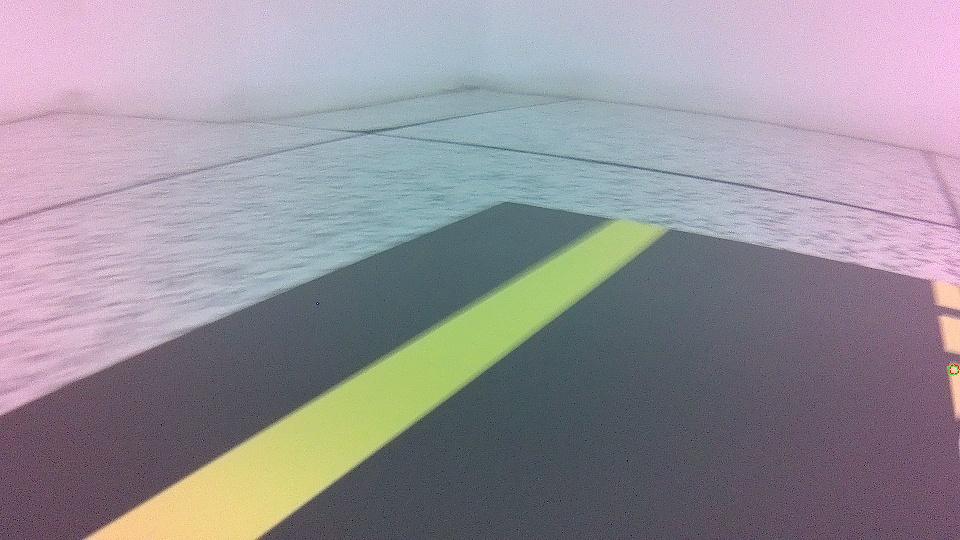

In [9]:
import cv2
import copy
import numpy as np
import PIL.Image

# img_filename_fmt = 'record/{}/{}_{{}}.jpg'.format(filename,filename)
img_filename = 'record/20240514_027/20240514_027_130.jpg'
# img_filename = '20240513_008/20240513_008_33.jpg'
ann_filename = 'dataset/annotation_straight_370_v3.txt'
with open(ann_filename, 'r') as f:
    data = [line.split() for line in f.readlines()]

# 해당 이미지 파일에 대한 어노테이션 정보 찾기
for line in data:
    filename, xpos, ypos = line[0], line[1], line[2]
    if filename == img_filename:
        xpos = int(xpos)
        ypos = int(ypos)
        break
else:
    print(f"{img_filename}에 해당하는 annotation 정보가 없습니다.")

image_ori = PIL.Image.open('record/20240514_027/20240514_027_130.jpg')
# image_ori = PIL.Image.open('20240513_008/20240513_008_23.jpg')
width = image_ori.width
height = image_ori.height

with torch.no_grad():
    image = preprocess(image_ori)
    output = model(image).detach().cpu().numpy()
x, y = output[0]

x = (x / 2 + 0.5) * width
y = (y / 2 + 0.5) * height

# 예측 위치 출력
print("예측 위치: x = {:.2f}, y = {:.2f}".format(x, y))

# 실제 위치(GT) 출력
if filename == img_filename:
    print("실제 위치(GT): x = {}, y = {}".format(xpos, ypos))

image_np = copy.deepcopy(np.asarray(image_ori))
cv2.circle(image_np, (int(x), int(y)), radius=5, color=(255, 0, 0))  # Pred
if filename == img_filename:
    cv2.circle(image_np, (xpos, ypos), radius=5, color=(0, 255, 0))     # GT

PIL.Image.fromarray(image_np)

